In [1]:
#!pip install tensorflow-gpu==2.0.0b1
%load_ext tensorboard
%matplotlib inline

# Diagnosis with an auto-encoder

based on Arvin Singh Kushwaha https://towardsdatascience.com/how-to-make-an-autoencoder-2f2d99cd5103

In [2]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np

import datetime

from tensorflow.keras.callbacks import TensorBoard

2.4.1


Training data with 6000 samples
Validation data with 10000 samples


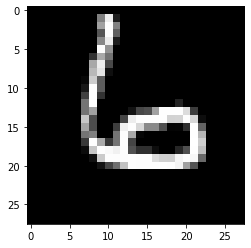

In [3]:
(x_train_all, y_train_all), (x_test_all, y_test_all) = mnist.load_data()

x_train_all = x_train_all/255.0
x_test_all = x_test_all/255.0

## Don't use everything: just a fraction of all available data
idx=np.random.choice(x_train_all.shape[0],int(0.1*x_train_all.shape[0]))

x_train = x_train_all[idx,:,:]
y_train = y_train_all[idx]

x_test = x_test_all
y_test = y_test_all

print("Training data with {0} samples".format(x_train.shape[0]))
print("Validation data with {0} samples".format(x_test.shape[0]))

# Plot image data from x_train
plt.imshow(x_train[0], cmap = "gray")
plt.show()

In [4]:
LATENT_SIZE = 16
encoder = Sequential([
    Flatten(input_shape = (28, 28)), # 784D
    Dense(64),
    LeakyReLU(),
    #Dropout(0.5),
    #Dense(64),
    #LeakyReLU(),
    #Dropout(0.5),
    Dense(LATENT_SIZE, activation="sigmoid"),
])

2021-09-30 14:35:42.274588: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-30 14:35:42.274832: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-30 14:35:42.275206: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
decoder = Sequential([
    Dense(64, input_shape = (LATENT_SIZE,)),
    LeakyReLU(),
    #Dropout(0.5),
    #Dense(128),
    #LeakyReLU(),
    Dense(784),
    Activation("sigmoid"),
    Reshape((28, 28))
])

In [6]:
img = Input(shape = (28, 28))
latent_vector = encoder(img)
output = decoder(latent_vector)
model = Model(inputs = img, outputs = output)
model.compile("nadam", loss = "MeanAbsoluteError", metrics=['Accuracy','Precision','Recall'])

In [7]:
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

## TensorBoard Callback
tcb = TensorBoard(log_dir=log_dir, histogram_freq=1)

EPOCHS = 30

history_callback = model.fit(x_train, x_train, 
                             batch_size = 64, epochs=EPOCHS,
                             validation_data=(x_test, x_test),
                             callbacks=[tcb])

2021-09-30 14:35:42.471301: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-30 14:35:42.471330: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-30 14:35:42.471376: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-30 14:35:42.546420: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-30 14:35:42.546849: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3199980000 Hz


Epoch 1/30
 4/94 [>.............................] - ETA: 7s - loss: 0.4714 - accuracy: 0.0000e+00 - precision: 0.1934 - recall: 0.4928

2021-09-30 14:35:44.037408: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-09-30 14:35:44.043156: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-09-30 14:35:44.073526: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-09-30 14:35:44.078185: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-09-30 14:35:44.103376: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210930-143542/train/plugins/profile/2021_09_30_14_35_44
2021-09-30 14:35:44.105613: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20210930-143542/train/plugins/profile/2021_09_30_14_35_44/bach.trace.json.gz
2021-09-30 14:35:44.132356: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210930-143542/train/plugins/profile/2021_09_30_

94/94 [==============================] - 6s 46ms/step - loss: 0.3401 - accuracy: 0.0000e+00 - precision: 0.2908 - recall: 0.2089 - val_loss: 0.1309 - val_accuracy: 0.0000e+00 - val_precision: 0.6879 - val_recall: 0.1229
Epoch 2/30
94/94 [==============================] - 3s 28ms/step - loss: 0.1285 - accuracy: 0.0000e+00 - precision: 0.6807 - recall: 0.1057 - val_loss: 0.1270 - val_accuracy: 0.0000e+00 - val_precision: 0.6985 - val_recall: 0.0786
Epoch 3/30
94/94 [==============================] - 4s 40ms/step - loss: 0.1265 - accuracy: 0.0000e+00 - precision: 0.6800 - recall: 0.0876 - val_loss: 0.1263 - val_accuracy: 0.0000e+00 - val_precision: 0.6952 - val_recall: 0.0828
Epoch 4/30
94/94 [==============================] - 3s 35ms/step - loss: 0.1259 - accuracy: 0.0000e+00 - precision: 0.6836 - recall: 0.0925 - val_loss: 0.1261 - val_accuracy: 0.0000e+00 - val_precision: 0.6969 - val_recall: 0.0830
Epoch 5/30
94/94 [==============================] - 5s 52ms/step - loss: 0.1255 - accur

In [8]:
%tensorboard --logdir logs/

313/313 [==============================] - 2s 7ms/step - loss: 0.1257 - accuracy: 0.0000e+00 - precision: 0.6904 - recall: 0.1051
Test score: [0.12567882239818573, 0.0, 0.6904434561729431, 0.10508205741643906]


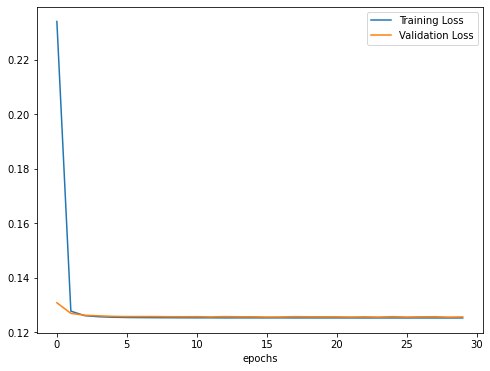

In [9]:
score = model.evaluate(x_test, x_test)
print('Test score:', score)

#acc = history_callback.history['accuracy']
loss = history_callback.history['loss']

#val_acc = history_callback.history['val_accuracy']
val_loss = history_callback.history['val_loss']

fig, (ax2) = plt.subplots(1,figsize=(8,6))
#ax1.plot(acc,label="Training Accuracy")
#ax1.plot(val_acc,label="Validation Accuracy")
ax2.plot(loss,label="Training Loss")
ax2.plot(val_loss,label="Validation Loss")

ax2.set_xlabel('epochs')
#ax1.legend()
ax2.legend()
plt.show()

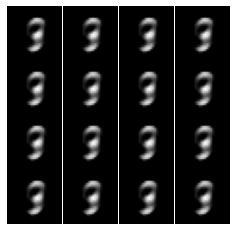

----------- EPOCH 0 -----------
94/94 [==============================] - 1s 12ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6802 - recall: 0.0957


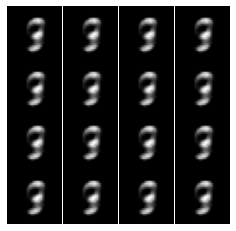

----------- EPOCH 1 -----------
94/94 [==============================] - 1s 10ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6815 - recall: 0.0922


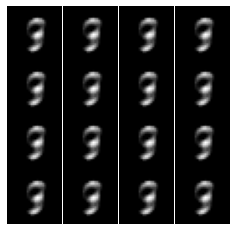

----------- EPOCH 2 -----------
94/94 [==============================] - 1s 10ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6827 - recall: 0.0933


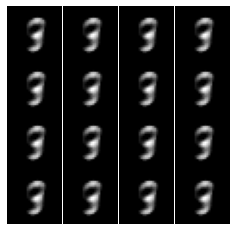

----------- EPOCH 3 -----------
94/94 [==============================] - 2s 22ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6805 - recall: 0.0963


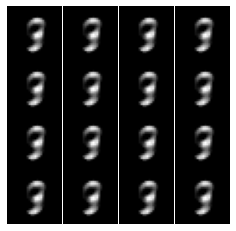

----------- EPOCH 4 -----------
94/94 [==============================] - 1s 12ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6826 - recall: 0.0945


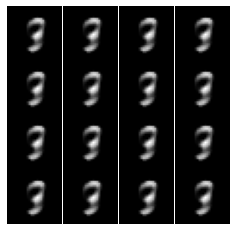

----------- EPOCH 5 -----------
94/94 [==============================] - 1s 15ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6818 - recall: 0.0915


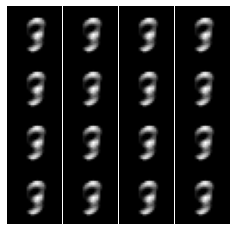

----------- EPOCH 6 -----------
94/94 [==============================] - 2s 17ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6824 - recall: 0.0905


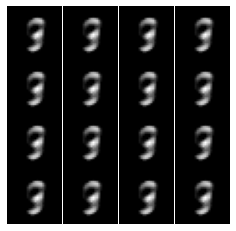

----------- EPOCH 7 -----------
94/94 [==============================] - 3s 30ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6812 - recall: 0.0960


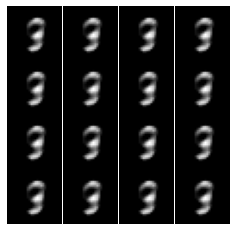

----------- EPOCH 8 -----------
94/94 [==============================] - 1s 10ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6802 - recall: 0.0957


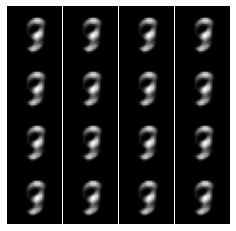

----------- EPOCH 9 -----------
94/94 [==============================] - 1s 11ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6801 - recall: 0.0920


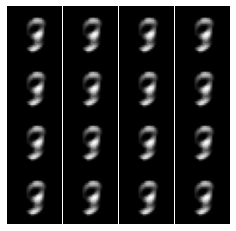

----------- EPOCH 10 -----------
94/94 [==============================] - 1s 14ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6812 - recall: 0.0992


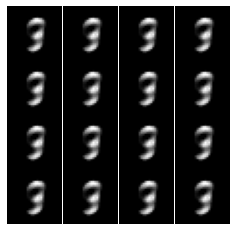

----------- EPOCH 11 -----------
94/94 [==============================] - 3s 28ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6811 - recall: 0.0916


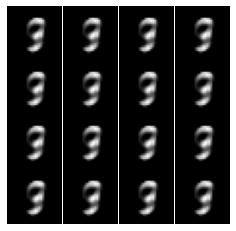

----------- EPOCH 12 -----------
94/94 [==============================] - 1s 10ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6827 - recall: 0.0923


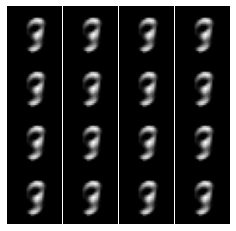

----------- EPOCH 13 -----------
94/94 [==============================] - 1s 10ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6819 - recall: 0.0949


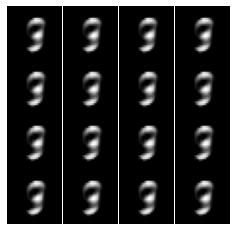

----------- EPOCH 14 -----------
94/94 [==============================] - 2s 18ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6804 - recall: 0.0913


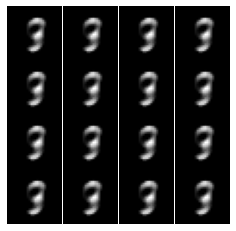

----------- EPOCH 15 -----------
94/94 [==============================] - 1s 13ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6821 - recall: 0.0927


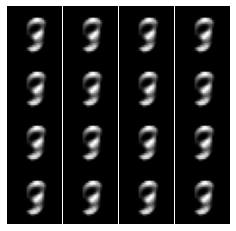

----------- EPOCH 16 -----------
94/94 [==============================] - 1s 15ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6817 - recall: 0.0931


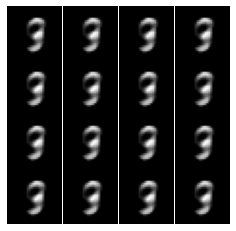

----------- EPOCH 17 -----------
94/94 [==============================] - 2s 20ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6805 - recall: 0.0937


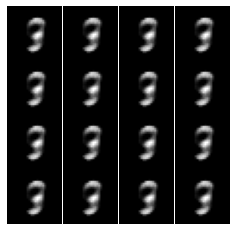

----------- EPOCH 18 -----------
94/94 [==============================] - 1s 14ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6824 - recall: 0.0887


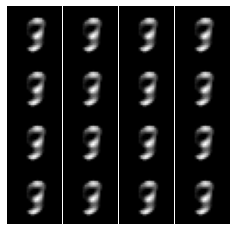

----------- EPOCH 19 -----------
94/94 [==============================] - 1s 15ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6819 - recall: 0.0900


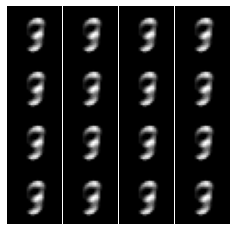

----------- EPOCH 20 -----------
94/94 [==============================] - 1s 6ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6795 - recall: 0.0952


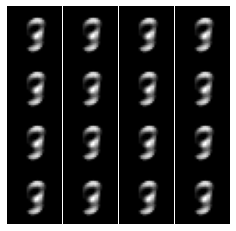

----------- EPOCH 21 -----------
94/94 [==============================] - 1s 11ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6811 - recall: 0.0999


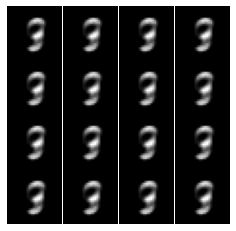

----------- EPOCH 22 -----------
94/94 [==============================] - 1s 15ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6822 - recall: 0.0943


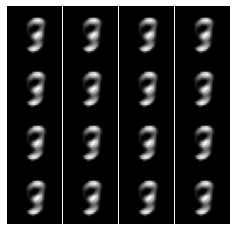

----------- EPOCH 23 -----------
94/94 [==============================] - 2s 23ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6828 - recall: 0.0891


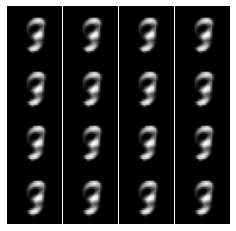

----------- EPOCH 24 -----------
94/94 [==============================] - 3s 36ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6830 - recall: 0.0879


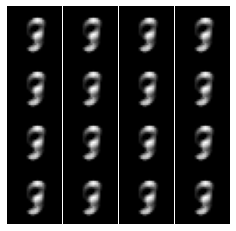

----------- EPOCH 25 -----------
94/94 [==============================] - 1s 12ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6819 - recall: 0.0943


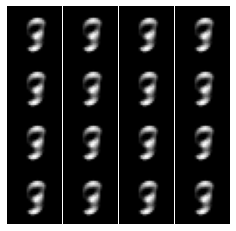

----------- EPOCH 26 -----------
94/94 [==============================] - 1s 16ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6814 - recall: 0.0956


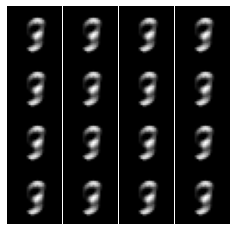

----------- EPOCH 27 -----------
94/94 [==============================] - 1s 11ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6810 - recall: 0.0940


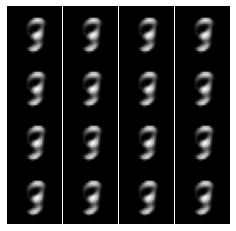

----------- EPOCH 28 -----------
94/94 [==============================] - 1s 12ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6834 - recall: 0.0928


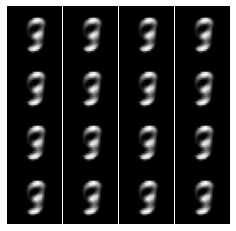

----------- EPOCH 29 -----------
94/94 [==============================] - 1s 9ms/step - loss: 0.1253 - accuracy: 0.0000e+00 - precision: 0.6826 - recall: 0.0905


In [10]:
#Only do plotting if you have IPython, Jupyter, or using Colab
for epoch in range(EPOCHS):
    fig, axs = plt.subplots(4, 4, figsize=(4,4))
    rand = x_test[np.random.randint(0, 10000, 16)].reshape((4, 4, 1, 28, 28))
    
    #display.clear_output() # If you imported display from IPython
    
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(model.predict(rand[i, j])[0], cmap = "gray")
            axs[i, j].axis("off")
    
    plt.subplots_adjust(wspace = 0, hspace = 0)
    plt.show()
    print("-----------", "EPOCH", epoch, "-----------")
    model.fit(x_train, x_train, batch_size = 64)